# Appendix
In this appendix, I showcase the code which I used for the analysis on the history of the idea of The West, which led to my MA thesis: “Onze Westerse Beschaving”: A Conceptual History of the Idea of the West in the Netherlands, 1875-1994. I have tried to include as many of the steps, which I have taken along the way, here in order to make my process insightful. Although this code was designed specifically with the data I had access to in mind, maybe somebody can get some use out of this. Anyone should feel free to use any part of this code for their own needs.

Edo Storm, 2022.

## Preprocessing
I will not be including the code for my preprocessing steps here, as the process was rather unoptimized and only really applicable to the format of my specific data, provided by Joris van Eijnatten. Including this code in a workable state, would mean incorporating the unprocessed data into this appendix, which I felt would make this appendix unnecessarily large. Furthermore, the data I used is not publicly available, and requires approval from the KB, Royal Library of the Netherlands. I will discuss the steps I took for preprocessing:

I first loaded all the data of a single year for all newspapers I was working with into memory, while removing stopwords, based on the 'stop_words_limited.txt' file, included in this appendix, I also removed all words with fewer than 3 characters, as those do not tend to be specifically meaningful. I removed all punctuation, special characters and numbers and replaced all capital letters, with lowercase ones. I then made sure the text was split every 25 words and would go into a new line. This was neccesary for training the word embedding models. I then put this text into a .txt file. This produced my processed data for a single year. To create data for the periods, I simply added the processed text of 10 single years together, to create a .txt file for a 10-year period.

## N-gram searches
Below is the code with the neccesary functions that I used to produce n-gram lists.

In [1]:
#neccessary imports for n-gram code
from nltk.util import ngrams
import collections
from os import listdir
import pandas as pd
from time import ctime

#neccesary global variables to specify paths
output_path = 'ngram_outputs/'
path_to_data_periods = 'txt_data_periods/'
#This is the amount of words per period. That is used for calculating relative frequencies.
#These have not been updated for the example data, so the relative frequencies will not be correct.
list_of_counts_periods = [77989948, 109009907, 231085214, 
                          320243898, 336609891, 398187727, 
                          247963606, 118153576, 261224229, 
                          310025731, 374344819, 446752058]

#this function creates a list of all the .txt files in the folder with .txt files.
def create_list_of_files():
    path = path_to_data_periods
    txt_files = listdir(path)
    txt_files = [f'{path}{i}' for i in txt_files]
    return txt_files

#This function opens up a single txt file, two lines at a time, to save on memory. It checks every two lines, for all 
#specified keywords, and returns a nested list of all n-grams, with frequencies.
def ngrams_w_term(txt_file, amount_of_words, words):
    list_of_all_ngrams = [[] for x in range(amount_of_words[1]-1)]
    with open(txt_file, "r", encoding='utf-8') as f:
        line1 = next(f)
        for line2 in f:
            for x in range(amount_of_words[0], amount_of_words[1]):
                if x == 1:
                    txt = line1.rstrip().split()
                else:
                    txt = line1.rstrip().split() + line2.rstrip().split()[:x-1]
                if txt:
                    all_ngrams = list(ngrams(txt, x))
                    list_of_all_ngrams[x - 1] += [ngram for ngram in all_ngrams if any(list(map(ngram.__contains__, words)))]
            line1 = line2

    ngrams_term_freq = [collections.Counter(list).most_common() for list in list_of_all_ngrams]
    return ngrams_term_freq

#This function formats the results of the n-grams into a legible dictionary, which later gets used to construct a .csv file.
#It only does so for a single period.
def create_dict_of_ngrams(ngrams, txt_file, ngram_len, title, index):
    dict_of_ngrams = {}
    dict_of_ngrams[f'{title} {ngram_len}-grams in {txt_file[-8:-4]}'] = [' '.join(i[0]) for i in ngrams]
    frequencies = [i[1] for i in ngrams]
    dict_of_ngrams[f'{title} {ngram_len}-grams count in {txt_file[-8:-4]}'] = frequencies
    sum_frequencies = sum(frequencies)
    dict_of_ngrams[f'total {ngram_len}-grams in {txt_file[-8:-4]}'] = [sum_frequencies]
    if ngram_len == 1:
        dict_of_ngrams[f'relative frequency in {txt_file[-8:-4]}'] = [
            ((sum_frequencies) / list_of_counts_periods[index]) * 100]
    return dict_of_ngrams

#This function calls all previous function, and outpuys the results in a .csv file. This is the function for the user to
#call, and specify their keywords and other variables.
def create_csv_file(words, title, n=[1,6]):
    list_of_dicts = [{} for x in range(n[1]-1)]
    txt_files = create_list_of_files()
    for index_1, txt_file in enumerate(txt_files):
        all_ngrams_in_file = ngrams_w_term(txt_file, n, words)
        for index_2, i in enumerate(all_ngrams_in_file):
            d = create_dict_of_ngrams(i, txt_file, index_2+1, title, index_1)
            list_of_dicts[index_2].update(d)
        print(f'done with {txt_file} at {ctime()}')

    for index, data in enumerate(list_of_dicts[n[0]-1:]):
        df = pd.DataFrame.from_dict(data=data, orient='index')
        df1 = df.transpose()
        df1.to_csv(f'{output_path}{title}_{index + n[0]}-gram_counts.csv', sep=';')
    print(f'!!!! CREATED CSV FOR {words}!!!!!!')

## Calling the n-gram functions
Below is an example of how these functions can be called to create .csv files of the most common n-grams. The user needs to specify a few variables.

- words: the words variable decides which keywords to look for. This can be one keyword or multiple ones, within a list object.
- title: Here the user can specify the title of the outputted .csv files. Make sure to change these, when switching keywords, as otherwise earlier files will be overwritten. This is a string object.
- n: With the n variable, the user can specify what n-gram lists to produce. This should be a list object, with two integers. The first int. specifies the lowest n-grams to produce (So 1 will produce unigrams) and the second will specify the cutoff for the length of n-grams. eg. [1,6] produces unigrams, bigrams, trigrams, 4-grams and 5-grams.

Because I could not make the data for my research publicly available, I replaced the data with example data, made up of texts from Project Gutenberg. Therefore this code is more of a proof-of-concept, and cannot reproduce the results which I used for my research project. If you want to use your own data with this, I recommend creating a chronological collection of your data, where the filenames end with the year of the data, as that is used in formatting the .csv files. For an example of this, check the 'txt_data_periods' folder. Replace the 'list_of_counts_periods' variable in the code above with a list of the total word counts for each .txt file in your dataset.

Because the example data I provided is quited small, this code will run rather quickly, but will not provide any significant insights, at least for the idea of the West. Feel free to play around with different keywords or data. The results can be found in the 'ngram_outputs' folder.

In [2]:
#An example of how I used this function to produce n-gram lists for the Western adjective.
#The results of calling this can be found in the 'ngram_outputs' folder.

create_csv_file(words = ['westers', 'westerse', 'westersch', 'westersche'], title = 'ngrams_western_adjective_example_data', n = [1,5])

done with txt_data_periods/00_Geschiedenis_der_Europeesche_Volken_1874.txt at Fri Aug 12 13:56:32 2022
done with txt_data_periods/01_Dominica_de_aarde_en_haar_volken_1904.txt at Fri Aug 12 13:56:32 2022
done with txt_data_periods/02_Uit_de_Ontwikkelingsgeschiedenis_van_het_menschelijk_denken_1908.txt at Fri Aug 12 13:56:32 2022
!!!! CREATED CSV FOR ['westers', 'westerse', 'westersch', 'westersche']!!!!!!


## Training the word embedding models

I used the TWEC implementation of Gensim's Word2Vec algorithm, as that provides a way of aligning all the words. While this would not necessarily have been necessary for how I used the model for this research project, alignment can be useful, if someone wanted to re-use these models. For more info on TWEC, please examine the following paper:

Valerio Di Carlo, Federico Bianchi, and Matteo Palmonari, “Training Temporal Word Embeddings with a Compass,” Proceedings of the AAAI Conference on Artificial Intelligence 33 (2019): pp. 6326-6334, https://doi.org/10.1609/aaai.v33i01.33016326.

TWEC requires a compass. This is a .txt file, containing all the data. It uses that for aligning words when training the models of the timeslices. The code I used for training the models looks as follows. As I could not include the raw .txt data, this code will not work. The models resulting from this procedure are included though.

If you wanted to train your own models, using this code, you would need:

- a chronological collection of data, pre-processed in the manner which I describe above. I chose to end the filenames of my .txt files with the period, which it covered, eg.: 'data_1875-1884.txt'. I based the variable 'YEARS' in the code below, on these names, so I could loop through the data. Change this variable, based on your own data and naming convention.
- a Compass file, named 'compass.txt'. This is simply a .txt file containing all the data of all periods. It is used for aligning words. This is specific to the TWEC implementation.

In [ ]:
from twec.twec import TWEC
from time import ctime
import os

print('started training TWEC aligner at '+ ctime())
YEARS = ['1875-1884','1885-1894','1895-1904','1905-1914','1915-1924','1925-1934','1935-1944','1945-1954',
         '1955-1964','1965-1974','1975-1984','1985-1994']
data_path = 'txt_data_periods/'

#These are the settings I used for this model. These settings are fairly standard. I did not have time to extinsively test
#other settings, due to time constraints.
aligner = TWEC(min_count=10,
                   window=5,
                   size=300,
                   alpha=0.03,
                   workers=7,
                   siter=10,
                   diter=30)

#This trains the compass, which takes the longest.
aligner.train_compass(data_path+'compass.txt', overwrite=False)
print('time: '+ ctime())

#I implemented this little for-loop, so the training can be cut up in multiple batches.
for year in YEARS:
    if os.path.isfile(f'model/data_{year}.model'):
        continue
    corpus_file = 'data_' + year + '.txt'
    aligner.train_slice(data_path+corpus_file, save=True)
    print('finished training time slice until ' + year + ' at ' + ctime())

I soon found out that I could not load all the full models into memory at one time, which was necessary for my needs. I opted to convert the full models to KeyedVectors instances, which are more memory efficient. These are the models which I included in the appendix.

The code for converting the models, is displayed in the next cell. However, I did not include the full models in the appendix, to keep the size down. So this code will not work.

In [ ]:
from gensim.models import Word2Vec, KeyedVectors

#note that this for loop uses the 'YEARS' variable once more.
for year in YEARS:
    model = Word2Vec.load(f'model/data_{year}.model')
    word_vectors = model.wv
    word_vectors.save(f'more_efficient_models/data_{year}.kv')

## Exploring the word embedding models

With the following blocks of code, I interrogated the trained models. I was unfortunarely not able to include the trained models in the appendix, as they were too large to be uploaded to github. If anyone would like access to the trained models, please get in touch:

emtstorm@hotmail.com

Without the models, this code will not work. The outputs displayed here were made using the models.

In [3]:
#neccesary imports
from gensim.models import KeyedVectors
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
YEARS_PERIODS = ['1875-1884','1885-1894','1895-1904','1905-1914','1915-1924','1925-1934','1935-1944','1945-1954',
         '1955-1964','1965-1974','1975-1984','1985-1994']
PATH_TO_MODEL = 'more_efficient_models/'
#this function loads all necessary models and puts them in a dictionary. It will take about 15 minutes to do so.
#Running this cell is necessary to interrogate the models.
def load_all_models():
    dict_of_models = {}
    for period in YEARS_PERIODS:
        print(f'working on {period}')
        dict_of_models[period] = KeyedVectors.load(f'{PATH_TO_MODEL}data_{period}.kv')
    return dict_of_models

#This loads the models into memory
dict_of_models = load_all_models()
print('done with creating dict of models')

working on 1875-1884
working on 1885-1894
working on 1895-1904
working on 1905-1914
working on 1915-1924
working on 1925-1934
working on 1935-1944
working on 1945-1954
working on 1955-1964
working on 1965-1974
working on 1975-1984
working on 1985-1994
done with creating dict of models


These are all the functions that I used to explore the model. With these functions, we can create a .csv file of the most similar words to one or multiple keywords throughout time, or produce graphs tracing the similarity of one or multiple keywords and a second set of one or multiple keywords.

In [5]:
#This function is used to create mean vectors for each timeslice, based on one or a number of keys
#It returns a dictionary with all the mean vector per timeslice
def create_mean_vecs(dict_of_models, keys):
    meta_vectors = {}
    for period in YEARS_PERIODS:
        meta_vec = []
        for key in keys:
            try:
                meta_vec.append(dict_of_models[period][key])
            except KeyError:
                continue
        meta_vectors[period] = np.mean(meta_vec, axis=0)
    return meta_vectors

#this function will generate a csv file based on the meta vecs most similar words
def get_most_similar_words(dict_of_models, mean_vecs, title):
    data_dict = {}
    for period in YEARS_PERIODS:
        list_of_tuples = dict_of_models[period].most_similar(mean_vecs[period], topn=100)
        data_dict[f'{period} words'] = [i[0] for i in list_of_tuples]
        data_dict[f'{period} scores'] = [i[1] for i in list_of_tuples]
        print(f'done with {period}')
    df = pd.DataFrame(data_dict)
    df.to_csv(f'word_embedding_outputs/{title}.csv', sep=';')
    
def calculate_cos_dis(mean_vecs_1, mean_vecs_2):
    list_of_indices = []
    list_of_lists = []
    for index, concept in enumerate(mean_vecs_2.keys()):
        nested_list = []
        for period in YEARS_PERIODS:
            if mean_vecs_2[concept][period] is not None:
                nested_list.append(1 - spatial.distance.cosine(mean_vecs_2[concept][period], mean_vecs_1[period]))
            else:
                nested_list.append(0)
        list_of_lists.append(nested_list)
        list_of_indices.append(f'{concept}')
    df = pd.DataFrame(data=list_of_lists, columns=YEARS_PERIODS, index=list_of_indices)
    print(df)
    return df

def make_plot_s(df, title, save=False):
    data = df.values.tolist()
    index_list = df.index.tolist()
    plt.rcParams["font.family"] = "Times New Roman"
    colors = ['black', 'silver']
    fig, ax = plt.subplots()
    x = range(12)
    for i in range(0, len(index_list)):
        plt.plot(x, data[i], color = colors[i], label=f'{index_list[i]}')
    plt.xticks(x, YEARS_PERIODS, rotation=25)
    plt.grid()
    label1 = plt.xlabel('time slices')#('$\it{time slices}$')
    label2 = plt.ylabel('cosine similarity')
    ax.set_ylim(ymin=0, ymax=1)
    lgd = fig.legend(loc='upper left', bbox_to_anchor = (0.1,0.90))
    plt.title(title)
    plt.tight_layout()
    plt.show()
    if save == True:
        fig.savefig(f'plots/{title}', bbox_extra_artists=(lgd, label1, label2), bbox_inches='tight')

This is an example of how I produced a .csv file of the most similar words to one or multiple target words, in this case, all spellings and forms of the Western adjective. This procedure consists of two steps. First, the user needs to create a mean_vecs variable, by calling the create_mean_vecs function. It creates a mean vector all the keywords the user specifies, allowing for the inclusion of multiple keywords or spellings of the same words. The required variable are:

- dict_of_models: Here we pass through the dictionary containing all the models, which we created using the load_all_models function
- keys: This should be a list of string, containing all the keywords the user chooses to include.
    
Then, we produce a .csv file of the most similar words to the mean_vecs by calling the get_most_similar_words function. This function requires the following variables:

- dict_of_models: The same as above.
- mean_vecs: the mean_vecs variable, created using the create_mean_vecs function.
- title: This requires a string, which will be the title of the .csv file, that gets produced.

In [7]:
mean_vecs = create_mean_vecs(dict_of_models = dict_of_models, keys = ['westers', 'westerse', 'westersch','westersche'])
print('created meta vec')

created meta vec


In [12]:
get_most_similar_words(dict_of_models, mean_vecs, 'similar words to Westers')

done with 1875-1884
done with 1885-1894
done with 1895-1904
done with 1905-1914
done with 1915-1924
done with 1925-1934
done with 1935-1944
done with 1945-1954
done with 1955-1964
done with 1965-1974
done with 1975-1984
done with 1985-1994


This is how I produced the graphs showcasing the similarity between Western and other terms. This is done using the calculate_cos_dis function. This function requires two variables, which are:

- mean_vecs_1: This variable is produced using the create_mean_vecs function of the previous example. The user has to specify the keywords upon which this variable is based.
- mean_vecs_2: This variable is a dictionary, which stores on or multiple mean_vectors, depending on how many concepts the user specifies. Simply create an empthy dictionary, and populate it mean_vectors. The dictionary key is used for labeling this mean vector.

In the example below, I compare mean vectors's simililarity to the Western adjective for Asian and Russian/Soviet

                1875-1884  1885-1894  1895-1904  1905-1914  1915-1924  \
Asian            0.465980   0.312403   0.493550   0.441739   0.523377   
Russian/Soviet   0.229332   0.133579   0.252977   0.251371   0.244320   

                1925-1934  1935-1944  1945-1954  1955-1964  1965-1974  \
Asian            0.519398   0.512616   0.680835   0.638512   0.602830   
Russian/Soviet   0.279970   0.380187   0.575228   0.562404   0.633952   

                1975-1984  1985-1994  
Asian            0.522815   0.524371  
Russian/Soviet   0.661794   0.629418  


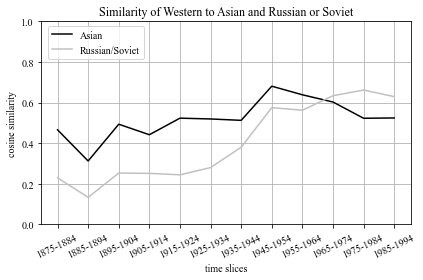

In [13]:
mean_vecs_1 = create_mean_vecs(dict_of_models, ['westers','westerse','westersch','westersche'])
mean_vecs_2 = {}
mean_vecs_2['Asian'] = create_mean_vecs(dict_of_models, ['aziatisch', 'aziatische'])
mean_vecs_2['Russian/Soviet'] = create_mean_vecs(dict_of_models, ['russisch', 'russische', 'sovjetunie', 'sovjetrusland','sovjet', 'sowjetunie', 'sowjetrusland', 'sowjet'])

df = calculate_cos_dis(mean_vecs_1, mean_vecs_2)
make_plot_s(df, 'Similarity of Western to Asian and Russian or Soviet', True)